## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna shap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gjdms\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [12]:
# ライブラリのインポート
import pandas as pd
import shap
import lightgbm as lgb
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation 
from imblearn.over_sampling import SMOTE

In [13]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_domain_age_clean_5.csv')

# url_type 컬럼에서 '2'인 데이터를 제외하고 '0'과 '1'인 데이터만 남기기
df = df[df['url_type'].isin([0, 1])]

best_params = {
    'boosting_type': 'goss',
    'learning_rate': 0.06327841043353384,
    'num_leaves': 146,
    'max_depth': 8,
    'min_data_in_leaf': 10,
    'feature_fraction': 0.7030308338054174,
    'lambda_l1': 2.675004037577347,
    'lambda_l2': 3.6723765368381396,
    'min_gain_to_split': 0.016110568656384494,
    'max_bin': 131
}

特徴量とラベルに分割

In [14]:
df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)

# log変換対象
df['TTFB_log'] = np.log1p(df['TTFB'])
df['LCP_log'] = np.log1p(df['LCP'])
df['FCP_log'] = np.log1p(df['FCP'])
# df['TBT_log'] = np.log1p(df['TBT'])  # ただし0の多さには注意

# 元の列は除外して、log変換版のみ使用
drop_cols = ['TTFB', 'LCP', 'FCP']
df = df.drop(columns=drop_cols)

# ターゲットと特徴量の分離
y = df['url_type']
X = df.drop(columns=['url_type'])

# X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count','is_domain_in_url'])

X['meta_count_high'] = (X['meta_count'] > 10).astype(int)
X['digit_ratio_bin'] = pd.cut(X['digit_ratio'], bins=[0, 0.02, 0.05, 0.1, 0.4], labels=False)
X['performance_ratio_log'] = np.log1p(X['performance_ratio'])

X = X.select_dtypes(include=['int64', 'float64', 'bool'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55750 entries, 0 to 59981
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   55750 non-null  object 
 1   url_type              55750 non-null  int64  
 2   url_len               55750 non-null  int64  
 3   letters_count         55750 non-null  int64  
 4   digits_count          55750 non-null  int64  
 5   special_chars_count   55750 non-null  int64  
 6   shortened             55750 non-null  int64  
 7   is_domain_in_url      55750 non-null  int64  
 8   secure_http           55750 non-null  int64  
 9   redirect_count        55750 non-null  int64  
 10  duration_sec          55750 non-null  float64
 11  meta_count            55750 non-null  float64
 12  link_count            55750 non-null  float64
 13  title_count           55750 non-null  float64
 14  has_title             55750 non-null  bool   
 15  has_meta_description  55

学習・検証データに分割

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [17]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

ハイパーパラメータ設定とモデル学習

In [18]:
# GOSS 의 경우는 bagging 계열 파라미터 삭제 (GOSS는 사용할 수 없음)
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 이진 분류를 위한 고정 설정 추가 및 수정
best_params.update({
    'objective': 'binary', # 이진 분류로 변경
    # 'num_class': y.nunique(), # 이진 분류에서는 필요 없으므로 제거 또는 주석 처리
    'metric': 'binary_logloss', # 이진 분류에 맞는 지표로 변경
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# 데이터셋의 재구축
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# num_boost_round 는 조기 종료되므로 크게 설정 (Optuna에 기록이 없는 경우)
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=30), # lgb.early_stopping으로 변경 (LightGBM 3.0 이상)
        lgb.log_evaluation(period=10) # lgb.log_evaluation으로 변경
    ]
)

Training until validation scores don't improve for 30 rounds
[10]	training's binary_logloss: 0.347838	valid_1's binary_logloss: 0.348112
[20]	training's binary_logloss: 0.212547	valid_1's binary_logloss: 0.213472
[30]	training's binary_logloss: 0.137415	valid_1's binary_logloss: 0.138512
[40]	training's binary_logloss: 0.0888587	valid_1's binary_logloss: 0.0901732
[50]	training's binary_logloss: 0.063197	valid_1's binary_logloss: 0.0647449
[60]	training's binary_logloss: 0.0462749	valid_1's binary_logloss: 0.0480778
[70]	training's binary_logloss: 0.0357094	valid_1's binary_logloss: 0.0377942
[80]	training's binary_logloss: 0.0271403	valid_1's binary_logloss: 0.0294457
[90]	training's binary_logloss: 0.0217462	valid_1's binary_logloss: 0.0241966
[100]	training's binary_logloss: 0.0175142	valid_1's binary_logloss: 0.0201736
[110]	training's binary_logloss: 0.0148155	valid_1's binary_logloss: 0.0177171
[120]	training's binary_logloss: 0.0128038	valid_1's binary_logloss: 0.0158429
[130]	t

予測と評価

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = model.predict(X_test)

# 이진 분류를 위한 예측 클래스 변환: 0.5를 기준으로 0 또는 1로 변환
y_pred = (y_pred_proba > 0.5).astype(int)

print("📊 Classification Report")
print(classification_report(y_test, y_pred, digits=5))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 이진 분류에서는 클래스가 0과 1뿐이므로 직접 지정
classes = [0, 1]

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            # 오분류된 데이터의 통계 요약 (필요시 사용)
            # 이진 분류에서는 한쪽 방향의 오분류만 실제 의미가 있습니다 (예: 0을 1로, 1을 0으로)
            # 여기서는 X_test[misclassified_mask]의 describe()를 출력합니다.
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0    0.99843   0.99721   0.99782      5745
           1    0.99704   0.99833   0.99769      5405

    accuracy                        0.99776     11150
   macro avg    0.99774   0.99777   0.99776     11150
weighted avg    0.99776   0.99776   0.99776     11150

🧩 Confusion Matrix
[[5729   16]
 [   9 5396]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 16
          url_len  letters_count  digits_count  special_chars_count  \
count   16.000000      16.000000       16.0000            16.000000   
mean    88.187500      74.250000        4.8125            16.125000   
std     15.091802      12.309888        3.2500             3.774917   
min     77.000000      60.000000        0.0000            10.000000   
25%     79.750000      65.750000        2.7500            14.000000   
50%     81.000000      72.000000        4.5000            15.000000   
75%     92.500000      78.250000        7.2500      

重要な特徴量を可視化

❗ クラス2→クラス0 の誤分類サンプルが見つかりませんでした。


c:\Users\gjdms\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

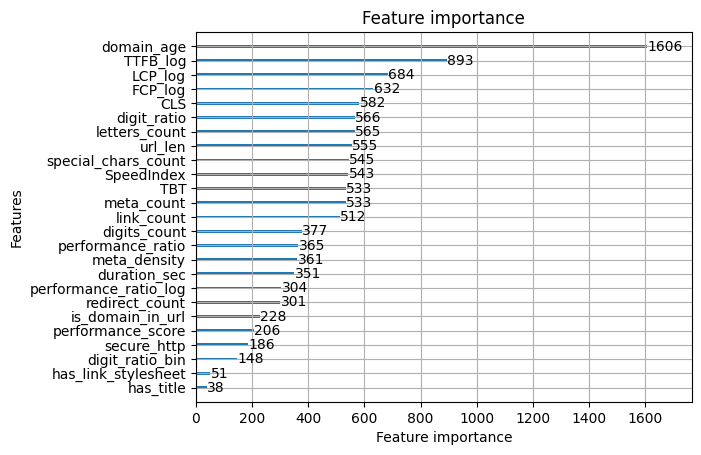

In [21]:
# -----------------------------
# ✅ SHAP 可視化
# -----------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# クラス2 → クラス0の誤分類サンプルに対する SHAP waterfall plot
wrong_mask = (y_test == 2) & (y_pred == 0)

if wrong_mask.sum() > 0:
    idx = np.where(wrong_mask)[0][0]
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[2][idx],
        base_values=explainer.expected_value[2],
        data=X_test.iloc[idx],
        feature_names=X_test.columns.tolist()
    ))
else:
    print("❗ クラス2→クラス0 の誤分類サンプルが見つかりませんでした。")

lgb.plot_importance(model, max_num_features=25)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

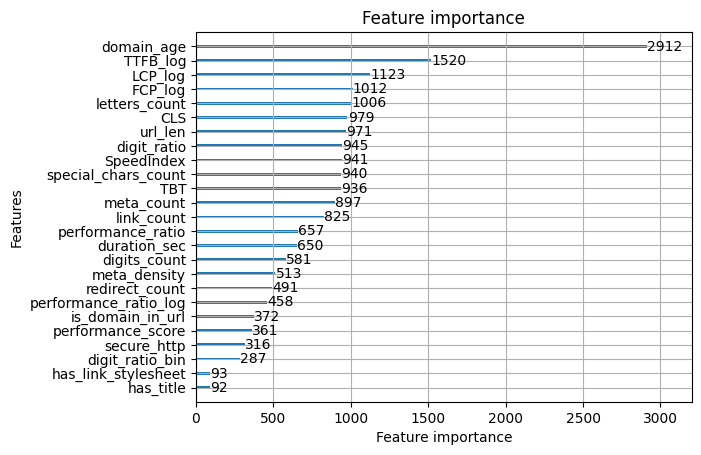

In [11]:
lgb.plot_importance(model, max_num_features=25)